# Emotion and Topic Features in the Israel–Palestine discussion for Reddit Engagement

This notebook analyzes how emotional and topical features of Reddit comments relate to engagement, using NRCLex and Empath features on the `asaniczka/reddit-on-israel-palestine-daily-updated` Kaggle dataset.

## Research Question

- How do emotional and topical characteristics of Reddit comments relate to user engagement across different subreddits in the Israel–Palestine discussion dataset?

### Sub-questions
- Which emotional expressions (for example: anger, trust, sadness) most strongly predict comment engagement?
- Which topical categories (for example: politics, violence, social interaction) are most associated with higher engagement?
- Do different subreddits show distinct emotional or topical patterns linked to higher engagement?
- Does combining emotion and topical features improve engagement prediction compared to using one feature type alone?

## Methodology

### 1. Data Source
- Use the “Reddit on Israel–Palestine – Daily Updated” dataset from Kaggle.
- Focus on the comments-level dataset.
- Keep comment text and engagement-related metadata.

### 2. Engagement Metric
- Construct a unified engagement score.
- Formula:
  - `engagement = ups + downs + score + controversiality`

### 3. Text Preprocessing
- Use `self_text` directly as text input.
- Remove empty or NaN comments.
- Optionally subsample the dataset for speed when debugging.

### 4. Feature Extraction
- **NRCLex Emotional Features**:
  - Extract 8 emotion categories: anger, fear, anticipation, trust, surprise, sadness, joy, disgust.
  - Use count-based emotion scores per comment.
- **Empath Topical Features**:
  - Extract LIWC-style normalized category scores per comment.
  - Capture content such as politics, violence, religion, social interaction, aggression, optimism, and others.
- **Combined Feature Set**:
  - Concatenate all NRCLex and Empath features into one matrix.

### 5. Model Construction
- Build three regression models to predict engagement:
  - Model A: NRCLex emotions only.
  - Model B: Empath topics only.
  - Model C: Combined emotion and topic features.
- Use RandomForestRegressor with standard scaling.
- Split data into train and test sets (80 percent train, 20 percent test).
- Evaluate using MAE and RMSE.

### 6. Subreddit-Level Analysis (Global model only)
- Do not train separate models per subreddit.
- Aggregate mean engagement and mean feature scores per subreddit.
- Generate subreddit-level summaries:
  - Average emotion levels.
  - Average topical category intensities.
  - Engagement distributions.
- Compute correlations between subreddit-level emotions or topics and engagement.
- Analyze which emotions or topics differentiate high-engagement subreddits.

### 7. Model Explainability
- Extract feature importances from the combined model.
- Identify which emotions or topics drive engagement globally.
- Inspect subreddit residual patterns to detect systematic under or over engagement.

### 8. Limitations and Ethics
- Lexicon-based features may not capture sarcasm or context.
- Engagement includes up and down votes, which differ by subreddit norms.
- Dataset is topical, so generalization is limited.
- Content is sensitive and geopolitical, so interpretation should be cautious.
- Emotional classification can misrepresent user intent and should not be used to target or inflame specific groups.

In [1]:
# !pip install nrclex empath kagglehub pandas scikit-learn

import kagglehub
import pandas as pd
import numpy as np

from nrclex import NRCLex
from empath import Empath

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

import matplotlib.pyplot as plt


In [5]:
# # Download latest dataset version
# path = kagglehub.dataset_download("asaniczka/reddit-on-israel-palestine-daily-updated")
# print("Path to dataset files:", path)

# comments_path = f"{path}/comments.csv"
comments_path = "reddit_opinion_PSE_ISR.csv"

df = pd.read_csv(comments_path)

# Keep only relevant columns
cols_keep = [
    "comment_id",
    "self_text",
    "score",
    "ups",
    "downs",
    "controversiality",
    "subreddit",
]
df = df[cols_keep]

# Drop rows without text
df = df.dropna(subset=["self_text"]).reset_index(drop=True)

print(df.head())
print("Subreddit counts:\n", df["subreddit"].value_counts().head(10))


  comment_id                                          self_text  score  ups  \
0    nricdgq  Israel left in 2005.\n\nThe blockade was estab...      1    1   
1    nriccrn  Gaza had 20 years and millions in aid money to...      1    1   
2    nricc9d  It's not genocidal and there really is no colo...      1    1   
3    nric51c  Israel has expelled Palestinians from half of ...      1    1   
4    nribzfv  I missed genocidal too. Also saying colonisati...      1    1   

   downs  controversiality        subreddit  
0      0                 0        worldnews  
1      0                 0        worldnews  
2      0                 0  IsraelPalestine  
3      0                 0  IsraelPalestine  
4      0                 0  IsraelPalestine  
Subreddit counts:
 subreddit
IsraelPalestine          1324128
worldnews                 851087
Palestine                 384228
PublicFreakout            268794
AskMiddleEast             221802
CombatFootage             153568
worldnewsvideo        

In [24]:
df

,comment_id,self_text,score,ups,downs,controversiality,subreddit,engagement
0,lglyh41,He was one of the presidents of the United Sta...,1,1,0,0,worldnews,2
1,no4bp8x,&gt;I can’t afford to bury my head in the sand...,2,2,0,0,IsraelPalestine,4
2,mvxueze,"funny that we never started any wars, each tim...",2,2,0,0,IsraelPalestine,4
3,n83de1y,According to Benny Morris the minority report ...,1,1,0,0,IsraelPalestine,2
4,k9hy8lr,"The short answer is if they are unarmed, there...",2,2,0,0,IsraelPalestine,4
...,...,...,...,...,...,...,...,...
19995,lwhaza0,The one Israeli on Twitter is representative o...,1,1,0,0,IsraelPalestine,2
19996,mpf6efl,Should they have accepted no sovereignty and a...,1,1,0,0,IsraelPalestine,2
19997,nqg41sr,Ukraine doesn't surrender legal claim to the t...,15,15,0,0,worldnews,30
19998,mpikp0h,"That's the ""my money don't jiggle jiggle it fo...",4,4,0,0,AskMiddleEast,8


In [6]:
# Define engagement metric
df["engagement"] = df["ups"] + df["downs"] + df["score"] + df["controversiality"]

print(df[["ups", "downs", "score", "controversiality", "engagement"]].describe())


                ups      downs         score  controversiality    engagement
count  3.518469e+06  3518469.0  3.518469e+06      3.518469e+06  3.518469e+06
mean   2.374694e+01        0.0  2.374694e+01      6.385078e-02  4.755772e+01
std    1.728833e+02        0.0  1.728833e+02      2.444870e-01  3.457589e+02
min   -1.352000e+03        0.0 -1.352000e+03      0.000000e+00 -2.704000e+03
25%    1.000000e+00        0.0  1.000000e+00      0.000000e+00  2.000000e+00
50%    3.000000e+00        0.0  3.000000e+00      0.000000e+00  6.000000e+00
75%    1.000000e+01        0.0  1.000000e+01      0.000000e+00  2.000000e+01
max    2.713500e+04        0.0  2.713500e+04      1.000000e+00  5.427000e+04


In [7]:
# Optional sampling for speed during development
N_SAMPLE = 20000  # set to None to use full dataset

if N_SAMPLE is not None and len(df) > N_SAMPLE:
    df = df.sample(N_SAMPLE, random_state=42).reset_index(drop=True)

print("Number of comments after sampling:", len(df))


Number of comments after sampling: 20000


In [26]:
import nltk

nltk.download("punkt")
# for newer NLTK versions the error mentions punkt_tab:
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\lachu\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\lachu\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt_tab.zip.


True

In [29]:
def extract_nrclex_features(text: str):
    emo = NRCLex(text)
    scores = emo.raw_emotion_scores
    return {cat: scores.get(cat, 0) for cat in EMOTION_CATS}


RAW: {'anticipation': 1, 'joy': 1, 'positive': 2, 'trust': 2}
RAW: {'positive': 2, 'sadness': 1, 'anger': 1, 'disgust': 1, 'negative': 1, 'anticipation': 1, 'joy': 1, 'trust': 1}
RAW: {'anticipation': 2, 'positive': 3, 'trust': 1, 'surprise': 1, 'fear': 1, 'negative': 1}
RAW: {'negative': 2, 'anticipation': 1, 'joy': 1, 'positive': 2, 'surprise': 1, 'trust': 1, 'anger': 1, 'fear': 1, 'sadness': 1}
RAW: {'anger': 1, 'fear': 2, 'negative': 3, 'positive': 1}


,anger,fear,anticipation,trust,surprise,sadness,joy,disgust
0,0,0,1,2,0,0,1,0
1,1,0,1,1,0,1,1,1
2,0,1,2,1,1,0,0,0
3,1,1,1,1,1,1,1,0
4,1,2,0,0,0,0,0,0


In [30]:
# NRCLex emotion feature extraction
EMOTION_CATS = [
    "anger",
    "fear",
    "anticipation",
    "trust",
    "surprise",
    "sadness",
    "joy",
    "disgust",
]

def extract_nrclex_features(text: str):
    emo = NRCLex(text)
    scores = emo.raw_emotion_scores
    return {cat: scores.get(cat, 0) for cat in EMOTION_CATS}

nrclex_features = df["self_text"].apply(extract_nrclex_features)
nrclex_df = pd.DataFrame(nrclex_features.tolist(), index=df.index)

print(nrclex_df.head())


   anger  fear  anticipation  trust  surprise  sadness  joy  disgust
0      0     0             1      2         0        0    1        0
1      1     0             1      1         0        1    1        1
2      0     1             2      1         1        0    0        0
3      1     1             1      1         1        1    1        0
4      1     2             0      0         0        0    0        0


In [31]:
nrclex_df

,anger,fear,anticipation,trust,surprise,sadness,joy,disgust
0,0,0,1,2,0,0,1,0
1,1,0,1,1,0,1,1,1
2,0,1,2,1,1,0,0,0
3,1,1,1,1,1,1,1,0
4,1,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
19995,0,1,0,0,0,0,0,0
19996,2,2,10,9,4,4,4,1
19997,0,2,1,3,1,1,1,1
19998,1,0,1,3,1,0,1,0


In [32]:
# Empath topical feature extraction
lexicon = Empath()

def extract_empath_features(text: str):
    """Return normalized scores for all Empath categories for one text."""
    try:
        return lexicon.analyze(text, normalize=True)
    except Exception:
        return lexicon.analyze("", normalize=True)

empath_features = df["self_text"].apply(extract_empath_features)
empath_df = pd.DataFrame(empath_features.tolist(), index=df.index)

print(empath_df.head())
print("Number of Empath categories:", len(empath_df.columns))


   help  office  dance  money  wedding  domestic_work  sleep  \
0   0.0     0.0    0.0    0.0      0.0            0.0    0.0   
1   0.0     0.0    0.0    0.0      0.0            0.0    0.0   
2   0.0     0.0    0.0    0.0      0.0            0.0    0.0   
3   0.0     0.0    0.0    0.0      0.0            0.0    0.0   
4   0.0     0.0    0.0    0.0      0.0            0.0    0.0   

   medical_emergency  cold  hate  ...    weapon  children  monster     ocean  \
0                0.0   0.0   0.0  ...  0.000000       0.0      0.0  0.000000   
1                0.0   0.0   0.0  ...  0.000000       0.0      0.0  0.041667   
2                0.0   0.0   0.0  ...  0.000000       0.0      0.0  0.000000   
3                0.0   0.0   0.0  ...  0.000000       0.0      0.0  0.000000   
4                0.0   0.0   0.0  ...  0.021277       0.0      0.0  0.000000   

   giving  contentment  writing  rural  positive_emotion  musical  
0     0.0          0.0      0.0    0.0               0.0      0.0 

In [33]:
# Build feature matrices for three models
target_col = "engagement"

model_A_data = pd.concat([nrclex_df, df[target_col]], axis=1)
model_B_data = pd.concat([empath_df, df[target_col]], axis=1)

combined_features = pd.concat([nrclex_df, empath_df], axis=1)
model_C_data = pd.concat([combined_features, df[target_col]], axis=1)

print("Model A shape (NRCLex only):", model_A_data.shape)
print("Model B shape (Empath only):", model_B_data.shape)
print("Model C shape (Combined):", model_C_data.shape)


Model A shape (NRCLex only): (20000, 9)
Model B shape (Empath only): (20000, 195)
Model C shape (Combined): (20000, 203)


In [34]:
def train_regression_model(df_features, target="engagement"):
    X = df_features.drop(columns=[target])
    y = df_features[target]

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = RandomForestRegressor(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train_scaled, y_train)

    preds = model.predict(X_test_scaled)

    mae = mean_absolute_error(y_test, preds)
    rmse = mean_squared_error(y_test, preds) ** 0.5  # FIXED LINE

    metrics = {"MAE": mae, "RMSE": rmse}

    return model, scaler, X_test, y_test, metrics


In [35]:
model_A, scaler_A, X_A_test, y_A_test, metrics_A = train_regression_model(model_A_data)
model_B, scaler_B, X_B_test, y_B_test, metrics_B = train_regression_model(model_B_data)
model_C, scaler_C, X_C_test, y_C_test, metrics_C = train_regression_model(model_C_data)

print(metrics_A, metrics_B, metrics_C)


{'MAE': 84.27047252367625, 'RMSE': 316.0011102902601} {'MAE': 82.66489533667263, 'RMSE': 364.54534139051907} {'MAE': 86.63761981263387, 'RMSE': 371.0965995995884}


In [36]:
# Feature importances for combined model
importances = model_C.feature_importances_
feature_names = model_C_data.drop(columns=[target_col]).columns

feat_imp = pd.DataFrame({
    "feature": feature_names,
    "importance": importances,
}).sort_values("importance", ascending=False)

print("Top 20 features by importance:")
print(feat_imp.head(20))

# Show importances for NRCLex emotion categories only
nrc_features_prefixed = [f for f in feature_names if f in EMOTION_CATS]
print("\nNRCLex emotion features in importance table:")
print(feat_imp[feat_imp["feature"].isin(nrc_features_prefixed)])


Top 20 features by importance:
                  feature  importance
109              sympathy    0.044371
128                listen    0.043016
107               hearing    0.042324
3                   trust    0.042257
8                    help    0.041588
81           independence    0.035843
24               vacation    0.029090
119  dominant_personality    0.028120
137                injury    0.028036
60               stealing    0.027085
2            anticipation    0.023591
112             anonymity    0.022814
75                hipster    0.017054
82               movement    0.014396
136                 sound    0.014249
76               internet    0.013853
196                giving    0.012116
0                   anger    0.011997
5                 sadness    0.011809
71               childish    0.010905

NRCLex emotion features in importance table:
          feature  importance
3           trust    0.042257
2    anticipation    0.023591
0           anger    0.011997
5    

In [37]:
# Build combined feature table with subreddit for analysis
full_feature_df = pd.concat(
    [
        df[["comment_id", "subreddit", "engagement"]],
        nrclex_df.add_prefix("nrc_"),
        empath_df.add_prefix("emp_"),
    ],
    axis=1,
)

print(full_feature_df.head())


  comment_id        subreddit  engagement  nrc_anger  nrc_fear  \
0    lglyh41        worldnews           2          0         0   
1    no4bp8x  IsraelPalestine           4          1         0   
2    mvxueze  IsraelPalestine           4          0         1   
3    n83de1y  IsraelPalestine           2          1         1   
4    k9hy8lr  IsraelPalestine           4          1         2   

   nrc_anticipation  nrc_trust  nrc_surprise  nrc_sadness  nrc_joy  ...  \
0                 1          2             0            0        1  ...   
1                 1          1             0            1        1  ...   
2                 2          1             1            0        0  ...   
3                 1          1             1            1        1  ...   
4                 0          0             0            0        0  ...   

   emp_weapon  emp_children  emp_monster  emp_ocean  emp_giving  \
0    0.000000           0.0          0.0   0.000000         0.0   
1    0.000000     

In [38]:
# Subreddit-level summary statistics
candidate_empath_cats = [
    "anger",
    "violence",
    "sadness",
    "joy",
    "politics",
    "religion",
    "money",
    "work",
    "social_media",
    "optimism",
    "negative_emotion",
    "positive_emotion",
]

actual_empath_cols = [
    f"emp_{c}" for c in candidate_empath_cats if f"emp_{c}" in full_feature_df.columns
]

nrc_cols = [c for c in full_feature_df.columns if c.startswith("nrc_")]

agg_dict = {"engagement": ["count", "mean", "median"]}
for col in nrc_cols + actual_empath_cols:
    agg_dict[col] = "mean"

subreddit_summary = full_feature_df.groupby("subreddit").agg(agg_dict)
subreddit_summary.columns = ["_".join(col).strip() for col in subreddit_summary.columns.values]
subreddit_summary = subreddit_summary.sort_values("engagement_count", ascending=False)

print(subreddit_summary.head(10))


                       engagement_count  engagement_mean  engagement_median  \
subreddit                                                                     
IsraelPalestine                    7576         4.031943                2.0   
worldnews                          4809       109.579538               16.0   
Palestine                          2250        41.649333               12.0   
PublicFreakout                     1521       118.693623               12.0   
AskMiddleEast                      1222        15.222586                6.0   
CombatFootage                       866        62.416859               10.0   
worldnewsvideo                      539        20.307978                6.0   
NonCredibleDefense                  514        79.797665               14.0   
CrazyFuckingVideos                  283        37.802120                4.0   
IsrealPalestineWar_23               122         3.836066                2.0   

                       nrc_anger_mean  nrc_fear_mea

In [39]:
# Correlation of subreddit-level averages with mean engagement
corrs = subreddit_summary.corr(numeric_only=True)["engagement_mean"].sort_values(ascending=False)
print("Top positive correlations with engagement_mean:")
print(corrs.head(20))
print("\nTop negative correlations with engagement_mean:")
print(corrs.tail(20))


Top positive correlations with engagement_mean:
engagement_mean              1.000000
engagement_median            0.679848
emp_work_mean                0.589408
emp_social_media_mean        0.323841
emp_optimism_mean            0.277030
emp_anger_mean              -0.027560
emp_negative_emotion_mean   -0.098553
engagement_count            -0.132867
emp_positive_emotion_mean   -0.155674
emp_money_mean              -0.190291
emp_joy_mean                -0.290286
emp_sadness_mean            -0.340455
emp_politics_mean           -0.346254
nrc_anticipation_mean       -0.404252
emp_violence_mean           -0.404935
nrc_trust_mean              -0.458249
nrc_joy_mean                -0.468969
nrc_surprise_mean           -0.488730
nrc_fear_mean               -0.573935
nrc_anger_mean              -0.588193
Name: engagement_mean, dtype: float64

Top negative correlations with engagement_mean:
emp_social_media_mean        0.323841
emp_optimism_mean            0.277030
emp_anger_mean              -

In [40]:
# Inspect a few top subreddits by comment count
top_subs = subreddit_summary.sort_values("engagement_count", ascending=False).head(5).index.tolist()
print("Top subreddits:", top_subs)

# Map base feature names to the aggregated column names (with _mean)
summary_nrc_cols = [f"{c}_mean" for c in nrc_cols if f"{c}_mean" in subreddit_summary.columns]
summary_empath_cols = [f"{c}_mean" for c in actual_empath_cols if f"{c}_mean" in subreddit_summary.columns]

cols_to_view = [
    "engagement_count",
    "engagement_mean",
    "engagement_median",
] + summary_nrc_cols + summary_empath_cols

print(subreddit_summary.loc[top_subs, cols_to_view])


Top subreddits: ['IsraelPalestine', 'worldnews', 'Palestine', 'PublicFreakout', 'AskMiddleEast']
                 engagement_count  engagement_mean  engagement_median  \
subreddit                                                               
IsraelPalestine              7576         4.031943                2.0   
worldnews                    4809       109.579538               16.0   
Palestine                    2250        41.649333               12.0   
PublicFreakout               1521       118.693623               12.0   
AskMiddleEast                1222        15.222586                6.0   

                 nrc_anger_mean  nrc_fear_mean  nrc_anticipation_mean  \
subreddit                                                               
IsraelPalestine        1.450766       1.784319               1.014388   
worldnews              0.723851       0.968393               0.632356   
Palestine              0.646667       0.760000               0.544889   
PublicFreakout         0.5

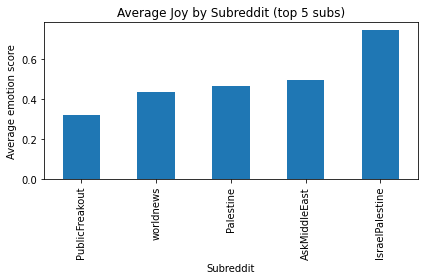

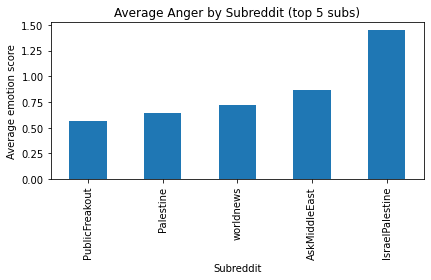

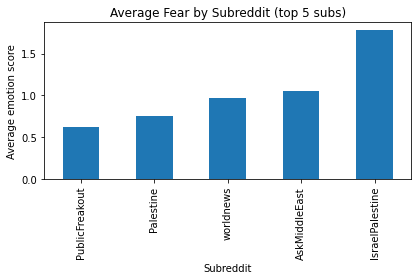

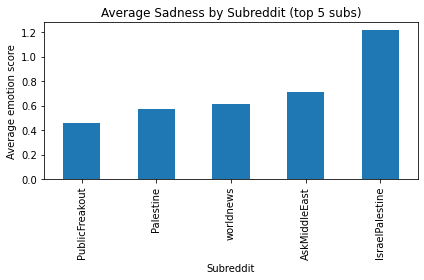

In [41]:
# Simple bar plots for a few emotions across top subreddits
plot_emotions = ["nrc_joy", "nrc_anger", "nrc_fear", "nrc_sadness"]

plot_df = subreddit_summary.loc[top_subs, [f"{e}_mean" for e in plot_emotions]]

for e in plot_emotions:
    col = f"{e}_mean"
    plt.figure()
    plot_df[col].sort_values().plot(kind="bar")
    plt.title(f"Average {e.replace('nrc_', '').title()} by Subreddit (top {len(top_subs)} subs)")
    plt.ylabel("Average emotion score")
    plt.xlabel("Subreddit")
    plt.tight_layout()
    plt.show()


In [42]:
# Residual analysis: which subreddits are over or under predicted by the global model?
X_all = model_C_data.drop(columns=[target_col])
y_all = model_C_data[target_col]

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_all,
    y_all,
    df.index,
    test_size=0.2,
    random_state=42,
)

X_test_scaled = scaler_C.transform(X_test)
y_pred = model_C.predict(X_test_scaled)

residuals = y_test.values - y_pred

res_df = pd.DataFrame({
    "engagement_true": y_test.values,
    "engagement_pred": y_pred,
    "residual": residuals,
    "subreddit": df.loc[idx_test, "subreddit"].values,
})

res_sub = res_df.groupby("subreddit")["residual"].mean().sort_values()
print("Subreddits with most negative mean residual (model overpredicts engagement):")
print(res_sub.head(10))
print("\nSubreddits with most positive mean residual (model underpredicts engagement):")
print(res_sub.tail(10))


Subreddits with most negative mean residual (model overpredicts engagement):
subreddit
worldnewsvideo          -80.609673
CrazyFuckingVideos      -74.558577
IsrealPalestineWar_23   -67.064432
IsraelPalestine         -59.631815
AskMiddleEast           -46.925567
AbruptChaos             -34.918075
ActualPublicFreakouts   -32.180076
NoahGetTheBoat          -18.048660
Palestine               -16.237839
CombatFootage            -0.586356
Name: residual, dtype: float64

Subreddits with most positive mean residual (model underpredicts engagement):
subreddit
AskMiddleEast           -46.925567
AbruptChaos             -34.918075
ActualPublicFreakouts   -32.180076
NoahGetTheBoat          -18.048660
Palestine               -16.237839
CombatFootage            -0.586356
PublicFreakout            3.258229
NonCredibleDefense        3.932518
TerrifyingAsFuck         38.126905
worldnews                47.961624
Name: residual, dtype: float64
